# ATMS 523 Final Project: Seasonal Variability of Ocean Swell Heights and Directions Affecting the Hawaiian Islands (1993–2024)
### Erin Welch

### INTRODUCTION:

This project examines how seasonal ocean wave conditions around the Hawaiian Islands vary in association with El Niño–Southern Oscillation (ENSO). Using ERA5 reanalysis wave fields and the official NOAA Oceanic Niño Index (ONI), we focus on how significant wave height (Hs) differs between El Niño and La Niña winters and how these variations may influence seasonal swell patterns affecting Hawaiʻi.

##### Background:

ENSO strongly modulates large-scale atmospheric circulation across the Pacific, which in turn alters extratropical storm tracks and wave generation regions. El Niño winters often produce enhanced North Pacific swell activity, while La Niña winters are associated with suppressed or shifted storm patterns. Understanding how Hs around Hawaiʻi varies by ENSO phase helps characterize seasonal surf potential and regional oceanographic variability.

##### Data:

- ERA5 Reanalysis – Single-Level Monthly Means
    - Variables: significant wave height (swh), mean wave direction (mwd), mean wave period (mwp)
    - Domain: 30°N–10°N, 170°W–150°W
    - Period: 1993–2024
    - DOI: https://doi.org/10.24381/cds.adbb2d47
    - **This data was obtained through the Copernicus Climate Data Store (cdsapi) but the downloaded data will be provided on Github for convenience**

- NOAA CPC Oceanic Niño Index (ONI)
    - Source: https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt
    - ONI is derived from ERSSTv5 (Huang et al. 2017; DOI: 10.7289/V5T72FNM)

##### Objectives:

- Compute seasonal (DJF) wave-height climatology around Hawaiʻi
- Derive ENSO-phase composites of DJF significant wave height using ERA5 and ONI
- Quantify differences in Hs between El Niño and La Niña winters
- Examine a time series of DJF Hs near the North Shore of Oʻahu to identify ENSO-related variability

##### Methods overview:

- Retrieve ERA5 wave fields and compute seasonal means using quarterly resampling
- Download official ONI values, extract DJF seasons, and classify ENSO phases
- Align ERA5 seasonal years with ONI by applying a +1 year shift
- Construct DJF composites for El Niño, La Niña, and composite differences
- Analyze regional climatology and point-based Hs variability

##### What “year” means in this study (clarifying DJF vs calendar year)

In this project, we work with seasonal (DJF) averages, not monthly values. Because the winter season spans two calendar years (December of one year and January/February of the next) we must choose one consistent definition of “year” so that ERA5 DJF values and ONI DJF values line up. Here, we assign the DJF season to the year of its January and February (ex., December 1997 January 1998 February 1998 = DJF 1998). We use this convention because December belongs to the winter that peaks in the following year, January and February dominate the winter signal, and it keeps all winter months aligned with the climatological year they mostly occur in.

The official Oceanic Niño Index (ONI), distributed by the NOAA Climate Prediction Center, assigns each 3-month season to the year of its January–February months (again, DJF 1998 in ONI corresponds to Dec 1997 + Jan 1998 + Feb 1998). Thus, the ONI row labeled DJF 1998 refers to the winter spanning 1997–98, and the label reflects the year of the core winter months (Jan–Feb 1998).

When ERA5 monthly data are converted to seasonal means using "swh.resample(time="QS-DEC").mean()" , xarray assigns each DJF seasonal mean a timestamp corresponding to the first day of December (ex., 1997-12-01). If we extract .dt.year directly from this timestamp, the season appears as 1997, even though the true climatological season is DJF 1998. Therefore, ERA5 resampling naturally labels DJF by the December year, whereas ONI labels DJF by the January–February year. This creates a systematic 1-year mismatch unless corrected.

To ensure correct alignment between ENSO phase (from ONI) and ERA5 seasonal wave fields, we label DJF by the year of its January–February months. Accordingly, we adjust the ERA5 seasonal labels by adding +1 to the December-based year, so that ERA5 DJF 1998 = Dec 1997, Jan 1998, Feb 1998 & ONI DJF 1998 = Dec 1997, Jan 1998, Feb 1998, etc... After this adjustment, ERA5 seasonal data and ONI ENSO classifications are perfectly aligned for all compositing and analysis.

This method is used because it matches the NOAA ONI labeling convention, it follows standard climatological practice for cross-year seasons, it ensures ERA5 DJF values are assigned to the same DJF year used by ENSO diagnostics and it avoids off-by-one errors in ENSO-conditioned composites.

In [1]:
# imports
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdsapi
from urllib.request import urlretrieve
import statsmodels.api as sm
from scipy.stats import pearsonr

### LOAD ERA5 WAVE DATA AROUND HAWAIʻI

The wave data for this project was downloaded from the Copernicus Climate Data Store using cdsapi. The data used in this project will also be accessible via github. To avoid downloading through CDS, clone the Github repository "ATMS523-Welch-Module8" and directly read in the provided ERA5 data: 

"78a4738e3be93cc08d43e0019ecb6c0a.nc"

In [ ]:
# Download ERA5 monthly significant wave height and mean direction around the Hawaiian Islands using cdsapi.
# format API request similar to Module 4 assignment!
#
# Dataset: "reanalysis-era5-single-levels-monthly-means"
# Variables:
#   - significant_height_of_combined_wind_waves_and_swell (Hs, m)
#   - mean_wave_direction (deg)
#
# Spatial domain: 30°N–10°N, 170°W–150°W
# Temporal range: 1993–2024 (monthly)- can expand temporal window as well!
#
# Data DOI: https://doi.org/10.24381/cds.f17050d7 

# initialize CDS API client (uses ~/.cdsapirc)
client = cdsapi.Client()

# dataset to use: ERA5 monthly-mean single-level fields (includes ocean-wave vars)
dataset = "reanalysis-era5-single-levels-monthly-means"

# API request
request = {
    # monthly means over the full month
    "product_type": ["monthly_averaged_reanalysis"],

    # years for the project (can adjust!)
    "year": [
        "1993", "1994", "1995",
        "1996", "1997", "1998",
        "1999", "2000", "2001",
        "2002", "2003", "2004",
        "2005", "2006", "2007",
        "2008", "2009", "2010",
        "2011", "2012", "2013",
        "2014", "2015", "2016",
        "2017", "2018", "2019",
        "2020", "2021", "2022",
        "2023", "2024"
    ],

    # all months: subset to DJF/JJA later in xarray
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],

    # monthly means at 00 UTC
    "time": ["00:00"],

    # same pattern as Module 4 code
    "data_format": "netcdf",
    "download_format": "unarchived",

    # key wave variables:
    #   - significant_height_of_combined_wind_waves_and_swell (Hs)
    #   - mean_wave_direction (mean direction, deg)
    #   - mean_wave_period (period will be used in analyses depending on time!)
    "variable": [
        "significant_height_of_combined_wind_waves_and_swell",
        "mean_wave_direction",
        "mean_wave_period"
    ],

    # spatial subset around the Hawaiian Islands 30°N–10°N, 170°W–150°W
    "area": [30, -170, 10, -150],
}

# retrieve and download
client.retrieve(dataset, request).download()

2025-12-09 09:27:12,599 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-12-09 09:27:13,502 INFO Request ID is bf3c85eb-53f1-4dfb-89ad-4ae0a46533fe
2025-12-09 09:27:13,801 INFO status has been updated to accepted
2025-12-09 09:27:28,549 INFO status has been updated to running
2025-12-09 09:28:06,127 INFO status has been updated to successful


'78a4738e3be93cc08d43e0019ecb6c0a.nc'

In [2]:
# read in using xarray
# SKIPTO THIS STEP if cloned from github

ds = xr.open_dataset('78a4738e3be93cc08d43e0019ecb6c0a.nc')

In [3]:
print(ds)

<xarray.Dataset> Size: 8MB
Dimensions:     (valid_time: 384, latitude: 41, longitude: 41)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 3kB 1993-01-01 ... 2024-12-01
  * latitude    (latitude) float64 328B 30.0 29.5 29.0 28.5 ... 11.0 10.5 10.0
  * longitude   (longitude) float64 328B -170.0 -169.5 -169.0 ... -150.5 -150.0
    expver      (valid_time) <U4 6kB ...
Data variables:
    swh         (valid_time, latitude, longitude) float32 3MB ...
    mwd         (valid_time, latitude, longitude) float32 3MB ...
    mwp         (valid_time, latitude, longitude) float32 3MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-09T19:27 GRIB to CDM+CF via cfgrib-0.9.1...


In [4]:
# clean up time dimension for xarray operability
ds = ds.rename({'valid_time': 'time'})

# add year and month from the time coordinate
ds = ds.assign_coords(
    year=('time', ds['time'].dt.year.values),
    month=('time', ds['time'].dt.month.values)
)

print(ds)

<xarray.Dataset> Size: 8MB
Dimensions:    (time: 384, latitude: 41, longitude: 41)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-12-01
  * latitude   (latitude) float64 328B 30.0 29.5 29.0 28.5 ... 11.0 10.5 10.0
  * longitude  (longitude) float64 328B -170.0 -169.5 -169.0 ... -150.5 -150.0
    expver     (time) <U4 6kB ...
    year       (time) int64 3kB 1993 1993 1993 1993 1993 ... 2024 2024 2024 2024
    month      (time) int64 3kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    swh        (time, latitude, longitude) float32 3MB ...
    mwd        (time, latitude, longitude) float32 3MB ...
    mwp        (time, latitude, longitude) float32 3MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Rang

/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)


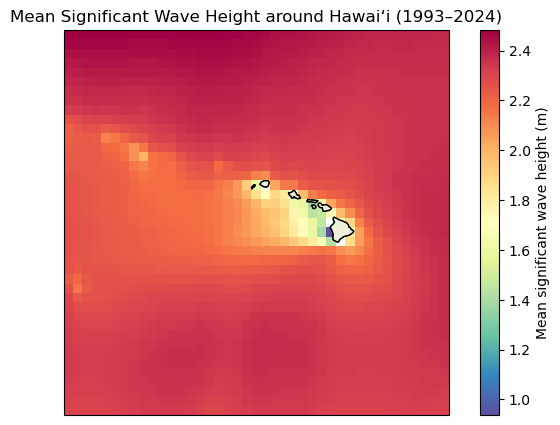

In [ ]:
# quick check: mean Hs map around Hawaiʻi

# retrieve swh 
swh = ds['swh']

# calculate mean swh
swh_mean = swh.mean('time')

# plot
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={'projection': proj})
swh_mean.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label': 'Mean significant wave height (m)'},
    cmap="Spectral_r"
)

# features and labels
ax.coastlines()
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=10)
ax.set_title('Mean Significant Wave Height around Hawaiʻi (1993–2024)')
plt.show()

# INTERPRETATION: 
#
# - spatial pattern: Leeward (south/east) low Hs, windward (north/west) higher Hs
# - this map shows a well-known and physically correct pattern:
#       - lower Hs immediately south of the islands: caused by island shadowing, where the terrain blocks north swell energy
#       - higher Hs north of the island chain: exposed to North Pacific winter swell, which dominates climatological wave energy in Hawaiʻi
#       - moderate Hs west of the islands: influenced by wrap-around refracted swell and occasional trade-wind swell contributions
#
# - in the context of this project:
#       - this map provides the baseline wave climate before incorporating ENSO variations. It shows:
#       - Hawaiʻi sits at the southern edge of strong North Pacific swell energy
#       - ENSO-related changes will likely be strongest north and northwest of the islands, where the swell generation region projects most strongly
#       - local influence near the North Shore will depend on how swell direction and energy shift between El Niño and La Niña winters

In [6]:
# Next, add year and month coords, and compute seasonal means using resampling

# we want to compute 3-month seasonal means from monthly data
# We'll use xarray's resample feature with the "QS-DEC" frequenc 
# ("QS" means quarterly start  "DEC" means quarters start in December)
# this results in seasons starting in December, March, June, and September,
# which correspond to DJF, MAM, JJA, and SON.

# seasonal means using quarterly resampling starting in December:
swh_q = swh.resample(time='QS-DEC').mean()

# define season names based on the starting month of each quarter
season = xr.DataArray(
    np.where(
        swh_q['time'].dt.month == 12, 'DJF',
        np.where(
            swh_q['time'].dt.month == 3, 'MAM',
            np.where(
                swh_q['time'].dt.month == 6, 'JJA', 'SON'
            )
        )
    ),
    coords={'time': swh_q['time']},
    dims='time'
)

# year label aligned with quarter start
year = swh_q['time'].dt.year

# put into a dataset and attach season/year as coordinates
swh_season = swh_q.to_dataset(name='swh')

swh_season['season'] = ('time', season.values)
swh_season["year"] = ("time", year.values + 1)

# print to confirm - now we have seasonal Hs with coords time, season, year
print(swh_season)


<xarray.Dataset> Size: 872kB
Dimensions:    (latitude: 41, longitude: 41, time: 129)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 328B 30.0 29.5 29.0 28.5 ... 11.0 10.5 10.0
  * longitude  (longitude) float64 328B -170.0 -169.5 -169.0 ... -150.5 -150.0
  * time       (time) datetime64[ns] 1kB 1992-12-01 1993-03-01 ... 2024-12-01
Data variables:
    swh        (time, latitude, longitude) float32 867kB 3.658 3.663 ... 2.85
    season     (time) <U3 2kB 'DJF' 'MAM' 'JJA' 'SON' ... 'JJA' 'SON' 'DJF'
    year       (time) int64 1kB 1993 1994 1994 1994 1994 ... 2025 2025 2025 2025


### DOWNLOAD AND PROCESS NOAA CPC ONI (OCEANIC NIÑO INDEX)

The official ONI values are stored in a plain text file at NOAA CPC: https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt

This file contains seasonal 3-month (running) means for Niño 3.4 SST anomalies, with columns:
- SEAS: season (ex., DJF, JFM, FMA)
- YR: year label
- TOTAL: mean SST over the Niño 3.4 box (°C)
- ANOM: anomaly relative to climatology (ONI value).

We will download this file directly from NOAA CPC using urlretrieve

In [7]:
# download official ONI from NOAA CPC using urlretrieve 
# OR read in provided ONI data from github repo ("oni_raw.txt")

# specify url and file name
oni_url = "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
oni_file = "oni_raw.txt"

# download to local
urlretrieve(oni_url, oni_file)

('oni_raw.txt', <http.client.HTTPMessage at 0x193f6bc90>)

In [8]:
# read and clean the raw ONI file into a pandas dataframe
# delim_whitespace=True tells pandas to split columns based on any whitespace (formatting used in this df)
oni = pd.read_csv(
    oni_file,
    delim_whitespace=True,
    names=["season", "year", "total_sst", "oni"], #rename columns for clarity
    header=0
)

# inspect
oni.head()

/var/folders/wv/kljb_44900987xbshx091lnc0000gn/T/ipykernel_444/368884152.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  oni = pd.read_csv(


,season,year,total_sst,oni
0,DJF,1950,24.72,-1.53
1,JFM,1950,25.17,-1.34
2,FMA,1950,25.75,-1.16
3,MAM,1950,26.12,-1.18
4,AMJ,1950,26.32,-1.07


In [9]:
# extract DJF-only ONI 
# In this project, we focus on DJF as a  "winter" season for swell impacts on Hawaiʻi. 
# Therefore, we only keep rows where season == "DJF"
oni_djf = oni[oni["season"] == "DJF"].copy()

# inspect
oni_djf.head()

,season,year,total_sst,oni
0,DJF,1950,24.72,-1.53
12,DJF,1951,25.42,-0.82
24,DJF,1952,26.78,0.53
36,DJF,1953,26.65,0.40
48,DJF,1954,27.00,0.76


In [10]:
# ENSO phase classification

# The "oni" column in oni_djf holds the seasonal ONI values - We now classify each DJF season into an ENSO phase:
#   - El Niño if ONI >= +0.5°C
#   - La Niña if ONI <= -0.5°C
#   - Neutral otherwise

conditions = [
    oni_djf["oni"] >= 0.5, # El Nino condition
    oni_djf["oni"] <= -0.5 # La Nina condition
]

choices = [
    "El Nino", # label when condition 0 (ONI >= 0.5) is True
    "La Nina"  # label when condition 1 (ONI <= -0.5) is True
    ] 

# applies the conditions to each row and picks the corresponding label from choices - "Neutral" when neither condition is True
oni_djf["phase"] = np.select(conditions, choices, default="Neutral")

# inspect
oni_djf

,season,year,total_sst,oni,phase
0,DJF,1950,24.72,-1.53,La Nina
12,DJF,1951,25.42,-0.82,La Nina
24,DJF,1952,26.78,0.53,El Nino
36,DJF,1953,26.65,0.40,Neutral
48,DJF,1954,27.00,0.76,El Nino
...,...,...,...,...,...
852,DJF,2021,25.59,-1.05,La Nina
864,DJF,2022,25.67,-0.97,La Nina
876,DJF,2023,25.96,-0.68,La Nina
888,DJF,2024,28.42,1.78,El Nino


In [11]:
# extract arrays of years for each ENSO phase. These will be used to compute composites of wave height in those years
el_nino_years = oni_djf.loc[oni_djf["phase"] == "El Nino", "year"].values
la_nina_years = oni_djf.loc[oni_djf["phase"] == "La Nina", "year"].values
neutral_years = oni_djf.loc[oni_djf["phase"] == "Neutral", "year"].values

# lists all DJF seasons from 1950–2025 classified into ENSO categories
print("El Niño DJF years:", el_nino_years)
print("La Niña DJF years:", la_nina_years)
print("Neutral DJF years:", neutral_years)

# INTERPRETATION:

# Classification of DJF seasons using the NOAA ONI identifies 27 El Niño winters, 31 La Niña winters, and 19 Neutral winters from 1950–2025. 
# When restricted to the 1993–2024 ERA5 period, these groups define the ENSO phases used to construct the DJF wave-height composites and govern the 
# interannual analysis of Hawaiian swell variability.

El Niño DJF years: [1952 1954 1958 1959 1964 1966 1969 1970 1973 1977 1978 1980 1983 1987
 1988 1992 1995 1998 2003 2005 2007 2010 2015 2016 2019 2020 2024]
La Niña DJF years: [1950 1951 1955 1956 1965 1968 1971 1972 1974 1975 1976 1984 1985 1989
 1996 1997 1999 2000 2001 2006 2008 2009 2011 2012 2018 2021 2022 2023
 2025]
Neutral DJF years: [1953 1957 1960 1961 1962 1963 1967 1979 1981 1982 1986 1990 1991 1993
 1994 2002 2004 2013 2014 2017]


### SELECT ERA5 DJF SEASONS AND COMPUTE ENSO COMPOSITES

In [12]:
# from swh_season, select entries where season == "DJF" to get a dataset of DJF seasonal means, each labeled with:
#   - time (December timestamp)
#   - season = "DJF"
#   - year   = climatological DJF year (Jan/Feb year, matching ONI)
swh_djf = swh_season.where(swh_season["season"] == "DJF", drop=True)

print(swh_djf[["season", "year"]].isel(time=slice(0, 8)))

<xarray.Dataset> Size: 200B
Dimensions:  (time: 8)
Coordinates:
    number   int64 8B 0
  * time     (time) datetime64[ns] 64B 1992-12-01 1993-12-01 ... 1999-12-01
Data variables:
    season   (time) object 64B 'DJF' 'DJF' 'DJF' 'DJF' 'DJF' 'DJF' 'DJF' 'DJF'
    year     (time) float64 64B 1.993e+03 1.994e+03 ... 1.999e+03 2e+03


In [ ]:
swh_djf["year"] = swh_djf["year"].astype(int)

# compute El Niño composite:
#   - select all DJF seasons whose "year" is in el_nino_years
#   - average Hs over the time dimension

swh_djf_el = swh_djf.where(
    swh_djf["year"].isin(el_nino_years),
    drop=True
)["swh"].mean("time")

# compute La Niña composite
#   - select all DJF seasons whose "year" is in la_nina_years
#   - average Hs over the time dimension
swh_djf_la = swh_djf.where(
    swh_djf["year"].isin(la_nina_years),
    drop=True
)["swh"].mean("time")

# compute composite difference: El Niño - La Niña
swh_djf_diff = swh_djf_el - swh_djf_la

### PLOT ENSO DJF COMPOSITE MAPS (EL NIÑO, LA NIÑA, DIFFERENCE)

/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value enco

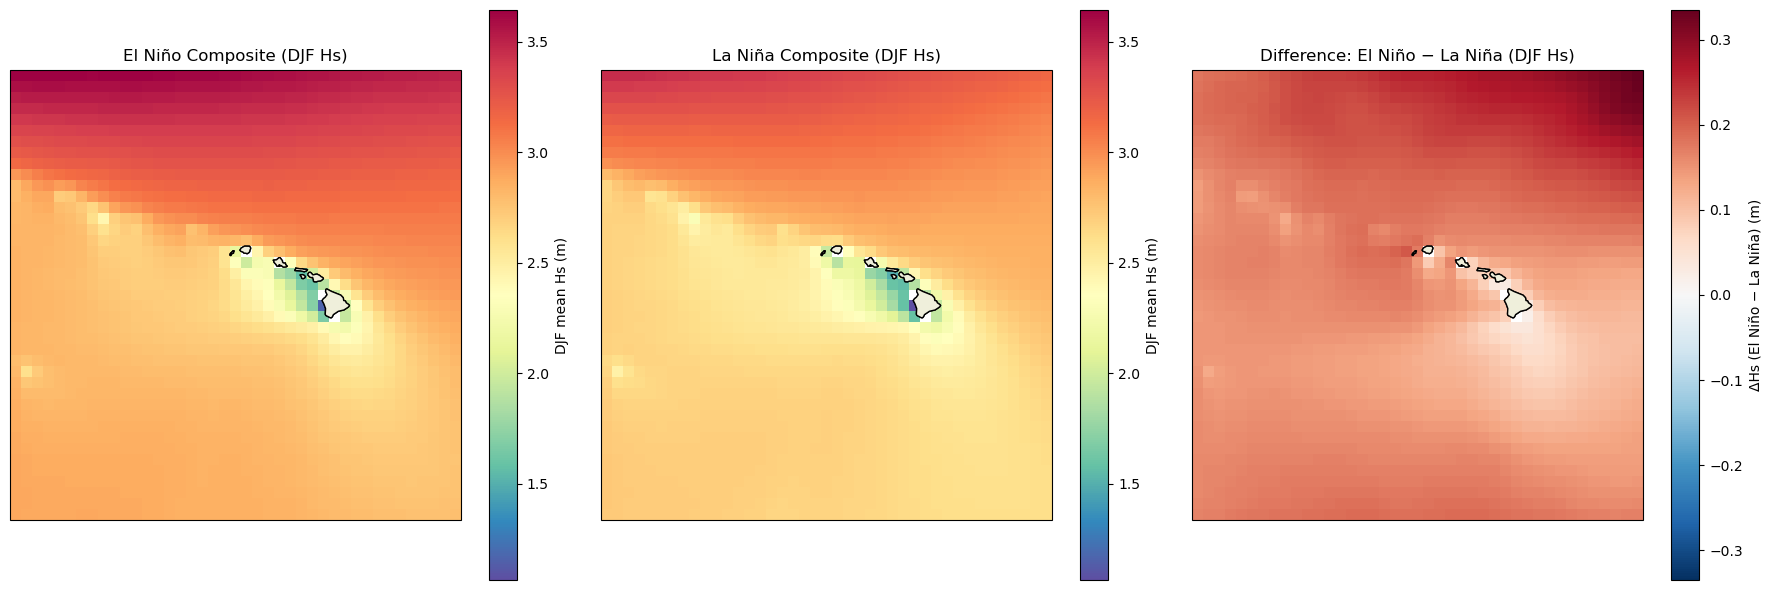

In [14]:
## DJF El Niño, La Niña, and Difference Maps

proj = ccrs.PlateCarree()

# create subplots
fig, axes = plt.subplots(
    ncols=3, figsize=(18, 6),
    subplot_kw={"projection": proj}
)

# shared color scale between El Niño and La Niña
cmap_main = "Spectral_r"  # For absolute values (El Niño & La Niña)
cmap_diff = "RdBu_r" # Divergent for the difference map

vmin = min(swh_djf_el.min(), swh_djf_la.min())
vmax = max(swh_djf_el.max(), swh_djf_la.max())

##########################
# PLOT 1 — El Niño Composite
p0 = swh_djf_el.plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap=cmap_main,
    vmin=vmin, vmax=vmax,
    cbar_kwargs={"label": "DJF mean Hs (m)"}
)

axes[0].coastlines()
axes[0].add_feature(cfeature.LAND, edgecolor="black", zorder=10)
axes[0].set_title("El Niño Composite (DJF Hs)")

##########################
# PLOT 2 - La Niña Composite Plot
p1 = swh_djf_la.plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap=cmap_main,
    vmin=vmin, vmax=vmax,
    cbar_kwargs={"label": "DJF mean Hs (m)"}
)

axes[1].coastlines()
axes[1].add_feature(cfeature.LAND, edgecolor="black", zorder=10)
axes[1].set_title("La Niña Composite (DJF Hs)")

##########################
# PLOT 3 - El Niño − La Niña Difference
# ================================
p2 = swh_djf_diff.plot(
    ax=axes[2],
    transform=ccrs.PlateCarree(),
    cmap=cmap_diff,
    center=0.0,
    cbar_kwargs={"label": "ΔHs (El Niño − La Niña) (m)"}
)

axes[2].coastlines()
axes[2].add_feature(cfeature.LAND, edgecolor="black", zorder=10)
axes[2].set_title("Difference: El Niño − La Niña (DJF Hs)")

# show
plt.tight_layout()
plt.show()


In [15]:
# check mean Hs over the whole domain for each composite
print("Domain-mean DJF Hs (El Niño):", float(swh_djf_el.mean()))
print("Domain-mean DJF Hs (La Niña):", float(swh_djf_la.mean()))

# check max difference
diff_max = float((swh_djf_el - swh_djf_la).max())
diff_min = float((swh_djf_el - swh_djf_la).min())
print("ΔHs max (El Niño – La Niña):", diff_max)
print("ΔHs min (El Niño – La Niña):", diff_min)

Domain-mean DJF Hs (El Niño): 2.9426369667053223
Domain-mean DJF Hs (La Niña): 2.7736737728118896
ΔHs max (El Niño – La Niña): 0.334810733795166
ΔHs min (El Niño – La Niña): 0.019918084144592285


##### INTERPREATION: ENSO DJF COMPOSITE MAPS

##### 1. El Niño Composite (DJF Hs)

- The northern portion of the domain shows larger significant wave heights (Hs) (values exceed 3.0–3.5 m), consistent with a more active North Pacific storm track during El Niño winters.
- Around the Hawaiian Islands, Hs is slightly elevated, with localized maxima NW of Oʻahu, but the enhancement is modest
- The spatial gradient from high Hs in the north to lower Hs near the equator (south side of the islands) is clearly visible

##### 2. La Niña Composite (DJF Hs)

- Overall pattern is similar (as expected), but northern-domain Hs values are slightly lower than during El Niño (around 2.8–3.2 m instead of 3.0–3.5 m)
- Around the islands, Hs is slightly reduced relative to El Niño but remains within a similar structure
- The Hawaiian Islands’ shadowing effect appears similar in structure, with minor intensity differences

##### 3. Difference Map (El Niño − La Niña)

This is where the ENSO signal becomes more clear:

- Positive differences dominate the entire domain, especially north of Hawaiʻi (∼+0.25 to +0.35 m), indicating El Niño winters consistently produce higher wave heights
- Near the islands, differences are modest (+0.05 to +0.15 m) but still positive, suggesting El Niño slightly strengthens winter swell reaching Hawaiʻi
- No areas show large negative values, meaning La Niña does not exceed El Niño wave heights anywhere in the regional domain
- The magnitude of differences is small relative to the large background Hs (~2–3 m), which explains why the El Niño and La Niña composites looked similar visually

##### Key Scientific Takeaways
- El Niño enhances North Pacific storm-wave activity, increasing regional swell energy that propagates toward Hawaiʻi
- La Niña slightly suppresses winter Hs, particularly north of Hawaiʻi, consistent with a weaker or more westward-shifted Aleutian Low
- The ENSO impact is detectable but modest near the islands, which is expected because these maps use monthly means, which smooth out individual large swell events
- Hawaiʻi’s complex bathymetry and island shadowing reduce the spatial contrast in coarse-resolution ERA5 data

### MONTHLY CLIMATOLOGY OF SIGNIFICANT WAVE HEIGHT OVER REGION

In [16]:
# compute a simple seasonal cycle by:
#   - averaging Hs over space (lat, lon)
#   - grouping by month and averaging over time

# ensure month coordinate exists
ds["month"] = ("time", ds["time"].dt.month.values)

# spatial mean over the Hawaiʻi wave domain
swh_space_mean = ds["swh"].mean(dim=("latitude", "longitude"))

# monthly climatology (mean Hs for each calendar month)
swh_monthly_clim = swh_space_mean.groupby("month").mean("time")

In [17]:
# inspect new dfs
print(swh_space_mean)

print(swh_monthly_clim)

<xarray.DataArray 'swh' (time: 384)> Size: 2kB
array([2.7491472, 2.9761713, 2.7441733, 2.5197427, 2.0459278, 1.8510966,
       2.0097764, 1.9040856, 1.6852202, 2.1591728, 2.5938857, 3.037727 ,
       2.8690004, 2.50604  , 2.8116288, 2.4890883, 2.1364322, 1.9395009,
       2.0211184, 2.011517 , 1.865779 , 2.1032116, 2.595521 , 3.0847523,
       3.132293 , 2.5652583, 2.679316 , 2.4857576, 2.072357 , 1.9619857,
       1.8918043, 1.9508688, 1.953602 , 2.083029 , 2.4353766, 2.7513144,
       2.6948671, 3.346245 , 2.6522849, 2.3984792, 1.8941622, 1.9176944,
       1.875531 , 1.6435016, 1.9384235, 2.1733682, 2.8791819, 2.9129694,
       2.8530118, 3.0210135, 2.5305386, 2.3390496, 2.0107105, 1.9687954,
       1.9783452, 1.8500673, 2.018332 , 2.195344 , 2.6022992, 2.9393826,
       3.3538997, 3.2048054, 2.621501 , 2.5402725, 2.2996008, 2.0505672,
       1.9053314, 1.9809916, 1.8273352, 2.2171054, 2.6472564, 3.070826 ,
       2.7812164, 2.9474819, 2.7772343, 2.299973 , 2.0385864, 1.9979784,
    

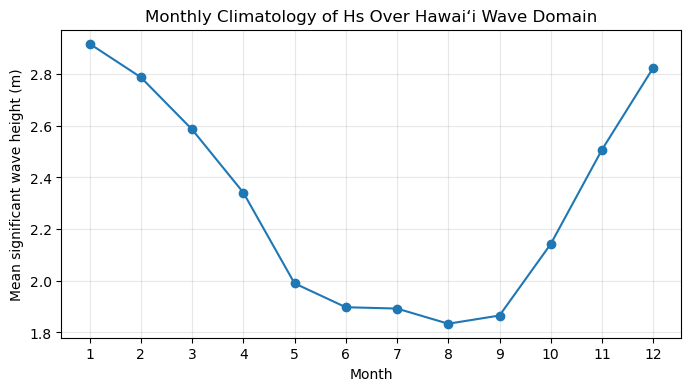

In [18]:
# plot
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    swh_monthly_clim["month"],
    swh_monthly_clim,
    marker="o"
)

ax.set_xticks(range(1, 13))
ax.set_xlabel("Month")
ax.set_ylabel("Mean significant wave height (m)")
ax.set_title("Monthly Climatology of Hs Over Hawaiʻi Wave Domain")
ax.grid(alpha=0.3)

plt.show()

# INTERPRETATION:

# - This plot shows the average monthly significant wave height across the broader Hawaiian wave domain (30–10°N, 170–150°W) for 1993–2024. 
#   The seasonal pattern is very strong and physically consistent with North Pacific wave climate.
# - Winter (DJF) is the dominant wave season
# - January shows the highest mean Hs (~2.9 m)
# - December and February are also elevated (consistent with peak North Pacific extratropical cyclone activity)
# - Hs drops sharply from March to April to May
# - By May, Hs is already nearing ~2.0 m, signaling the transition to summer trade-wind–dominated wave climate
# - June–September have the lowest mean Hs (~1.85–1.9 m)
# - This shows the flat season for north-facing shores: North Pacific storm activity is minimal & surf in generally smaller
# - October–November show rising Hs, marking the onset of early North Pacific winter storms
# - November already reaches ~2.5 m, showing the approaching big-wave season
# - The difference between winter peak and summer minimum is ~1 meter which is a large and climatologically meaningful swing

### DJF TIME SERIES AT A SURF-RELEVANT POINT (NORTH SHORE OʻAHU)

In [19]:
# choose approximate coordinates for North Shore Oʻahu.
# these are approximate - we will select the nearest ERA5 grid point
lat_pt = 21.6 
lon_pt = 201.9

# extract the DJF seasonal Hs at the nearest grid cell to this location
swh_djf_point = swh_djf["swh"].sel(
    latitude=lat_pt,
    longitude=lon_pt,
    method="nearest"
)

# convert the xarray time series to a pandas series (convenience)
swh_djf_series = swh_djf_point.to_series()

# put into a DataFrame
swh_djf_df = swh_djf_series.to_frame(name="swh_djf")

In [20]:
# inspect

print(swh_djf_series)

# the index of swh_djf_df is the seasonal time stamp (ex., 1997-12-01)
print(swh_djf_df)

time
1992-12-01    2.873183
1993-12-01    2.846366
1994-12-01    2.996143
1995-12-01    3.002100
1996-12-01    2.915233
1997-12-01    3.272307
1998-12-01    3.185829
1999-12-01    2.821605
2000-12-01    2.826936
2001-12-01    3.224244
2002-12-01    3.068943
2003-12-01    2.872436
2004-12-01    2.794768
2005-12-01    2.960794
2006-12-01    3.080577
2007-12-01    2.784966
2008-12-01    2.716200
2009-12-01    2.873111
2010-12-01    2.576677
2011-12-01    2.831421
2012-12-01    3.123065
2013-12-01    2.611179
2014-12-01    2.810889
2015-12-01    3.169509
2016-12-01    2.700660
2017-12-01    2.836728
2018-12-01    2.927149
2019-12-01    2.990648
2020-12-01    2.899949
2021-12-01    2.603955
2022-12-01    2.939628
2023-12-01    2.938971
2024-12-01    2.873480
Name: swh, dtype: float32
             swh_djf
time                
1992-12-01  2.873183
1993-12-01  2.846366
1994-12-01  2.996143
1995-12-01  3.002100
1996-12-01  2.915233
1997-12-01  3.272307
1998-12-01  3.185829
1999-12-01  2.821605


In [21]:
# extract the climatological DJF year using the swh_djf["year"] coordinate
# merge from the xarray "year" coord so we keep 1:1 mapping

# create a small DataFrame with ERA5 seasonal year labels
era5_years_df = swh_djf[["year"]].to_dataframe().reset_index()

# merge the ERA5 year into the point time series by matching on "time"
swh_djf_df = swh_djf_df.reset_index().merge(
    era5_years_df,
    on="time",
    how="left"
)

# rename "year" column for clarity: this is the DJF year (Jan/Feb year)
swh_djf_df = swh_djf_df.rename(columns={"year": "djf_year"})

# merge ENSO phase information from oni_djf using the DJF year
swh_djf_df = swh_djf_df.merge(
    oni_djf[["year", "phase"]].rename(columns={"year": "djf_year"}),
    on="djf_year",
    how="left"
)

In [22]:
print("DJF point time series near Oʻahu with ENSO phase:")
print(swh_djf_df)

DJF point time series near Oʻahu with ENSO phase:
         time   swh_djf  djf_year  number    phase
0  1992-12-01  2.873183      1993       0  Neutral
1  1993-12-01  2.846366      1994       0  Neutral
2  1994-12-01  2.996143      1995       0  El Nino
3  1995-12-01  3.002100      1996       0  La Nina
4  1996-12-01  2.915233      1997       0  La Nina
5  1997-12-01  3.272307      1998       0  El Nino
6  1998-12-01  3.185829      1999       0  La Nina
7  1999-12-01  2.821605      2000       0  La Nina
8  2000-12-01  2.826936      2001       0  La Nina
9  2001-12-01  3.224244      2002       0  Neutral
10 2002-12-01  3.068943      2003       0  El Nino
11 2003-12-01  2.872436      2004       0  Neutral
12 2004-12-01  2.794768      2005       0  El Nino
13 2005-12-01  2.960794      2006       0  La Nina
14 2006-12-01  3.080577      2007       0  El Nino
15 2007-12-01  2.784966      2008       0  La Nina
16 2008-12-01  2.716200      2009       0  La Nina
17 2009-12-01  2.873111      201

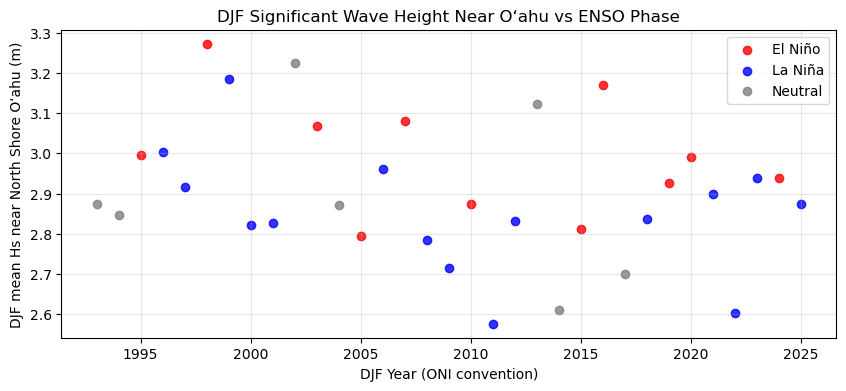

In [23]:
# create masks for each ENSO phase
mask_el = swh_djf_df["phase"] == "El Nino"
mask_la = swh_djf_df["phase"] == "La Nina"
mask_neu = swh_djf_df["phase"] == "Neutral"

# plot DJF Hs at the Oʻahu point, colored by ENSO phase
fig, ax = plt.subplots(figsize=(10, 4))

# El Niño years (red)
ax.scatter(
    swh_djf_df.loc[mask_el, "djf_year"],
    swh_djf_df.loc[mask_el, "swh_djf"],
    label="El Niño",
    color="red",
    alpha=0.8
)

# La Niña years (blue)
ax.scatter(
    swh_djf_df.loc[mask_la, "djf_year"],
    swh_djf_df.loc[mask_la, "swh_djf"],
    label="La Niña",
    color="blue",
    alpha=0.8
)

# Neutral years (gray)
ax.scatter(
    swh_djf_df.loc[mask_neu, "djf_year"],
    swh_djf_df.loc[mask_neu, "swh_djf"],
    label="Neutral",
    color="gray",
    alpha=0.8
)

ax.set_xlabel("DJF Year (ONI convention)")
ax.set_ylabel("DJF mean Hs near North Shore Oʻahu (m)")
ax.set_title("DJF Significant Wave Height Near Oʻahu vs ENSO Phase")
ax.legend()
ax.grid(alpha=0.3)

plt.show()

# INTERPRETATION: 

# - Winters classified as El Niño generally appear toward the higher end of the wave height values in the dataset
# - La Niña winters tend to fall on the lower end of the distribution compared to the other phases
# - Neutral winters mostly occupy the middle range, not consistently aligning with either high or low values
# - Despite these tendencies, there is substantial overlap between all three ENSO groups, showing that ENSO phase could influence wave height but does not determine it
# - Several winters in each category do not follow the typical pattern, highlighting the importance of natural year-to-year variability in North Pacific storm activity
# - The spread in the scatterplot indicates that factors other than ENSO also play a significant role in controlling wave climate near Oʻahu
# - Overall, the plot suggests a modest shift in the distribution of winter wave heights depending on ENSO phase, 
#   with El Niño leaning higher and La Niña leaning lower, but with considerable variability across all groups

### POINT-BASED LINEAR RELATIONSHIP BETWEEN DJF Hs AND ONI USING OLS (NORTH SHORE)

describe what is done here and how its connected to class

In [ ]:
# merge numeric ONI value into the DJF point time series (already have djf_year and phase in swh_djf_df)
swh_djf_df = swh_djf_df.merge(
    oni_djf[["year", "oni"]].rename(columns={"year": "djf_year", "oni": "oni_djf"}),
    on="djf_year",
    how="left"
)

# drop any rows with missing Hs or ONI
swh_djf_reg = swh_djf_df.dropna(subset=["swh_djf", "oni_djf"])

# predictor (x) = DJF ONI, response (y) = DJF mean Hs near Oʻahu
x = swh_djf_reg["oni_djf"].values
y = swh_djf_reg["swh_djf"].values

# add a constant term for the intercept: y = β0 + β1 * x
X = sm.add_constant(x)

# fit Ordinary Least Squares regression
model = sm.OLS(y, X).fit()

# print full regression summary
print(model.summary())

# INTERPRETATION

# - The regression shows a statistically significant but modest linear relationship between DJF ONI and DJF significant wave height near Oʻahu
# - The slope coefficient (0.0706) indicates that each +1°C increase in ONI is associated with an increase of about 7 cm in seasonal mean wave height
# - The p-value for the slope (0.009) confirms that this relationship is statistically significant at the 1% level
# - The R-squared value (0.199) shows that ONI accounts for about 20% of the winter-to-winter variability in wave height, meaning ENSO influences 
#   wave climate but does not dominate it
# - The intercept (2.9139) represents the estimated winter mean wave height when ONI is zero
# - Residual diagnostics (Omnibus and Jarque–Bera tests) do not indicate problems with normality
# - The Durbin–Watson statistic (1.775) suggests no concerning autocorrelation in the residuals
# - Overall, the results support a real but moderate ENSO effect on winter swell energy, with most variability driven by other atmospheric and oceanic processes

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     7.717
Date:                Tue, 09 Dec 2025   Prob (F-statistic):            0.00920
Time:                        15:06:05   Log-Likelihood:                 15.380
No. Observations:                  33   AIC:                            -26.76
Df Residuals:                      31   BIC:                            -23.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9139      0.027    106.485      0.0

In [25]:
# compute Pearson correlation as an additional diagnostic
r_val, p_val = pearsonr(x, y)

print(f"\nPearson r between DJF ONI and Hs (Oʻahu): {r_val:.3f}")
print(f"p-value: {p_val:.4f}")

# INTERPRETATION: 

# - The correlation between DJF ONI and DJF wave height near Oʻahu is 0.446, indicating a moderate positive relationship
# - Higher ONI values (El Niño conditions) tend to be associated with higher winter wave heights
# - The p-value of 0.0092 shows that this correlation is statistically significant, meaning the relationship is unlikely to be due to random chance
# - Although significant, the correlation is not very strong, suggesting that ENSO influences wave height but most year-to-year variability 
#   is still driven by other factors such as individual storm activity


Pearson r between DJF ONI and Hs (Oʻahu): 0.446
p-value: 0.0092


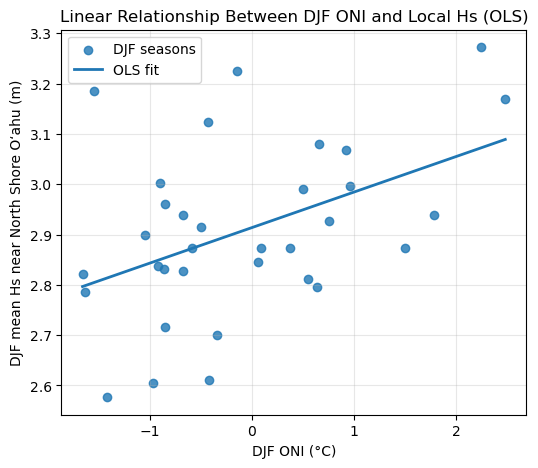

In [ ]:
# extract regression parameters for plotting
intercept = model.params[0]
slope = model.params[1]

# Scatter plot with OLS regression line
fig, ax = plt.subplots(figsize=(6, 5))

# Scatter of observations
ax.scatter(x, y, alpha=0.8, label="DJF seasons")

# Regression line over the range of observed ONI values
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = intercept + slope * x_fit
ax.plot(x_fit, y_fit, label="OLS fit", linewidth=2)

ax.set_xlabel("DJF ONI (°C)")
ax.set_ylabel("DJF mean Hs near North Shore Oʻahu (m)")
ax.set_title("Linear Relationship Between DJF ONI and Local Hs (OLS)")
ax.grid(alpha=0.3)
ax.legend()

plt.show()

# INTERPREATION 

# - The scatterplot shows a positive relationship between DJF ONI and DJF significant wave height near Oʻahu
# - As ONI increases (moving toward El Niño conditions), wave heights tend to increase
# - The fitted OLS line visually confirms this upward trend, consistent with the regression slope of about 0.07 m per +1°C ONI
# - The data points show substantial scatter, indicating that ONI influences wave height but does not fully determine it
# - Several winters with similar ONI values produce different wave heights, showing the strong role of natural storm-to-storm variability
# - The overall pattern supports a moderate ENSO influence: El Niño winters generally appear higher on the y-axis, and La Niña winters lower, 
#   but with noticeable overlap between categories
# - The plot aligns with the correlation result (r ≈ 0.45), showing a relationship that is statistically significant but not strong

### SPATIAL CORRELATION BETWEEN DJF Hs AND ONI

In [27]:
# reindex DJF ERA5 data by 'year' instead of the December timestamp
# swh_djf has dims: time, latitude, longitude with coords 'year' and 'season'
# swap_dims makes 'year' the primary dimension for the seasonal series
swh_djf_year = swh_djf.swap_dims({"time": "year"}).sortby("year")

# keep only the years that overlap between ERA5 DJF and ONI DJF
common_years = np.intersect1d(
    swh_djf_year["year"].values,
    oni_djf["year"].values
)

swh_djf_common = swh_djf_year.sel(year=common_years)

# inspect
print(swh_djf_common)

<xarray.Dataset> Size: 223kB
Dimensions:    (year: 33, latitude: 41, longitude: 41)
Coordinates:
  * year       (year) int64 264B 1993 1994 1995 1996 ... 2022 2023 2024 2025
    number     int64 8B 0
  * latitude   (latitude) float64 328B 30.0 29.5 29.0 28.5 ... 11.0 10.5 10.0
  * longitude  (longitude) float64 328B -170.0 -169.5 -169.0 ... -150.5 -150.0
    time       (year) datetime64[ns] 264B 1992-12-01 1993-12-01 ... 2024-12-01
Data variables:
    swh        (year, latitude, longitude) float32 222kB 3.658 3.663 ... 2.85
    season     (year) object 264B 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF'


In [28]:
# build a 1D xarray DataArray of ONI values indexed by 'year'
oni_djf_common = xr.DataArray(
    oni_djf.set_index("year")["oni"].loc[common_years].values,
    coords={"year": common_years},
    dims="year",
    name="oni_djf"
)

print("Common DJF years used for spatial correlation:", common_years)

Common DJF years used for spatial correlation: [1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023 2024 2025]


In [ ]:
# compute Pearson correlation between Hs and ONI along the 'year' dimension
# xr.corr broadcasts oni_djf_common over the latitude/longitude grid
corr_map = xr.corr(
    swh_djf_common["swh"],
    oni_djf_common,
    dim="year"
)

# inspect
print(corr_map)

<xarray.DataArray (latitude: 41, longitude: 41)> Size: 13kB
array([[0.50198166, 0.51800506, 0.53183373, ..., 0.69392813, 0.69654166,
        0.69998673],
       [0.51229056, 0.52696959, 0.54044001, ..., 0.70312268, 0.70681834,
        0.71035225],
       [0.51876046, 0.53206026, 0.54573136, ..., 0.71456444, 0.71749561,
        0.71890521],
       ...,
       [0.56584403, 0.56459384, 0.56396894, ..., 0.45489234, 0.45581603,
        0.45746981],
       [0.57165713, 0.57235809, 0.57256409, ..., 0.47008723, 0.47063726,
        0.47238066],
       [0.57961736, 0.58139189, 0.58194238, ..., 0.48737074, 0.48747488,
        0.48827426]], shape=(41, 41))
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 328B 30.0 29.5 29.0 28.5 ... 11.0 10.5 10.0
  * longitude  (longitude) float64 328B -170.0 -169.5 -169.0 ... -150.5 -150.0


/opt/anaconda3/envs/climate/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/climate/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)


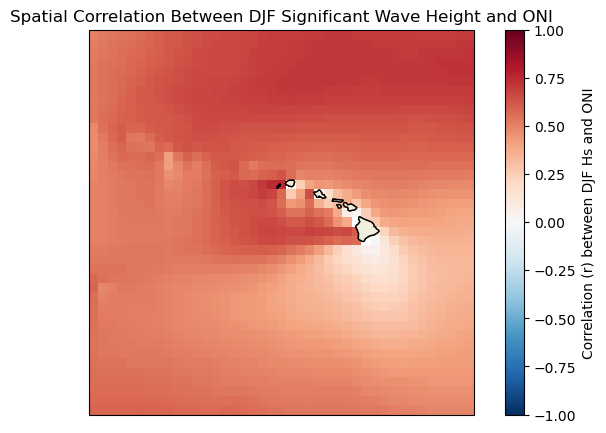

In [ ]:
# plot the correlation map
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": proj})

corr_map.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin=-1, vmax=1,
    cmap="RdBu_r", 
    cbar_kwargs={"label": "Correlation (r) between DJF Hs and ONI"}
)

ax.coastlines()
ax.add_feature(cfeature.LAND, edgecolor="black", zorder=10)
ax.set_title("Spatial Correlation Between DJF Significant Wave Height and ONI")

plt.show()

# INTERPRETATION: 

# - The map shows the spatial correlation between DJF ONI and DJF significant wave height across the Hawaiian wave domain
# - Most of the region displays positive correlations, meaning winters with higher ONI (El Niño conditions) tend to have higher wave heights
# - Correlations are generally moderate, roughly in the 0.2–0.5 range over much of the area
# - The strongest correlations appear north and northwest of the islands, consistent with the primary swell-generation region in winter
# - Near the islands, correlations remain positive but are somewhat lower, suggesting local effects (island blocking, bathymetry, shadow zones) 
#   reduce the strength of the ENSO signal
# - No areas show strong negative correlations, indicating El Niño does not reduce wave heights anywhere in the regional domain
# - Overall, the pattern suggests a basin-scale ENSO influence on North Pacific wave climate, with Hawaiʻi receiving a modest but geographically consistent signal

### OPTIONAL ANALYSES: ZOOM IN ON HAWAIIAN ISLANDS

<xarray.DataArray 'swh' (latitude: 15, longitude: 17)> Size: 1kB
array([[2.3355634, 2.3304508, 2.3216403, 2.3175395, 2.3284256, 2.3376567,
        2.331167 , 2.3272033, 2.3274686, 2.3234603, 2.319386 , 2.3174825,
        2.318506 , 2.3231223, 2.330455 , 2.3379643, 2.3436542],
       [2.316655 , 2.3092844, 2.2964518, 2.2935767, 2.3126671, 2.3245788,
        2.315125 , 2.3143659, 2.3181603, 2.3141997, 2.3112013, 2.3094995,
        2.3111336, 2.317343 , 2.3265493, 2.3355753, 2.3430521],
       [2.2697701, 2.2720597, 2.2562044, 2.2528617, 2.288157 , 2.305742 ,
        2.292579 , 2.2974524, 2.3044508, 2.3004954, 2.2998185, 2.3000453,
        2.3032262, 2.3122373, 2.3233962, 2.3332658, 2.3416464],
       [2.2142053, 2.19502  , 2.1234128, 2.0984533, 2.2304416, 2.2638888,
        2.2516549, 2.2751338, 2.2886689, 2.2861855, 2.2887118, 2.2887475,
        2.2931583, 2.3043923, 2.3187108, 2.3318923, 2.341747 ],
       [2.0700243, 1.9244634, 1.5923449,       nan, 2.0386612, 2.1434538,
        2.141

/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)


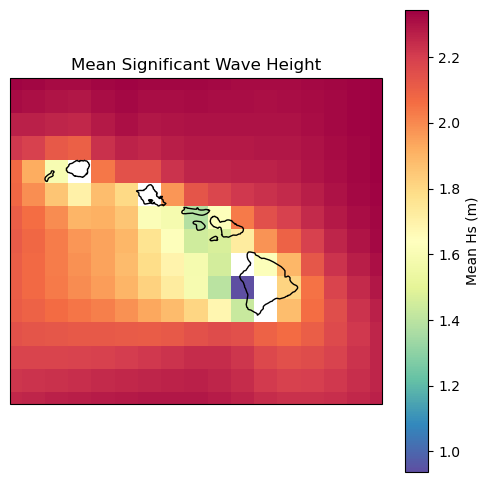

In [ ]:
# re-plot mean significant wave height near the Hawaiian Islands

# approximate Hawaiian islands box
lat_min, lat_max = 17.0, 24.0
lon_min, lon_max = -161, -153

# zoom in using provided coordinates
swh_zoom = swh_mean.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max)
)

# inspect
print(swh_zoom)

# and plot
fig, ax = plt.subplots(figsize=(6, 6),
                       subplot_kw={"projection": ccrs.PlateCarree()})

swh_zoom.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Mean Hs (m)"},
    cmap="Spectral_r"
)

ax.coastlines()
ax.set_title("Mean Significant Wave Height")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

plt.show()


/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/opt/anaconda3/envs/climate/lib/python3.11/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value enco

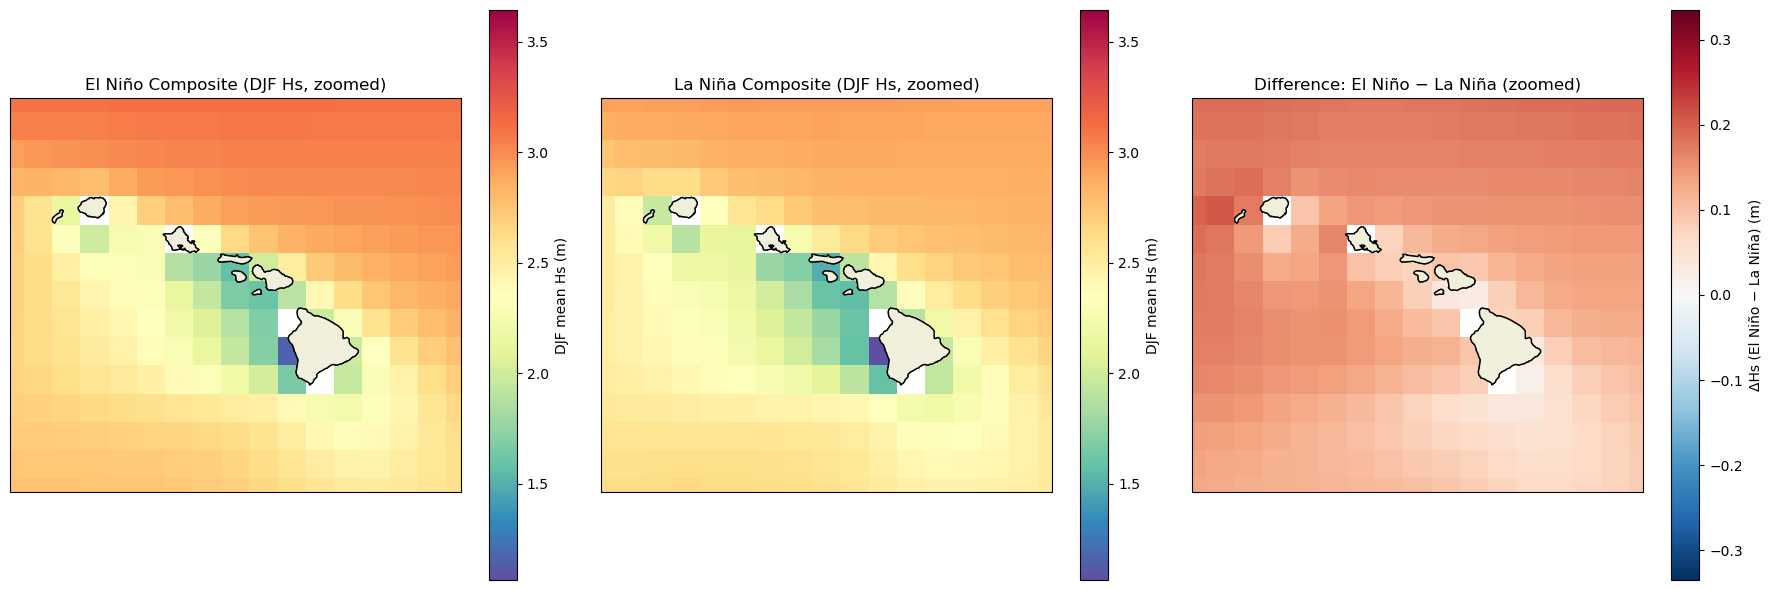

In [35]:
# re-plot Hs - ENSO composites near the Hawaiian Islands

proj = ccrs.PlateCarree()

# define zoom box around Hawaiʻi
lat_min, lat_max = 17.0, 24.0
lon_min, lon_max = -161, -153
zoom_box = [lon_min, lon_max, lat_min, lat_max]

# shared colormaps
cmap_main = "Spectral_r" # for El Niño & La Niña
cmap_diff = "RdBu_r"  # for difference

# shared color range for El Niño / La Niña
vmin = float(xr.concat([swh_djf_el, swh_djf_la], dim="comp").min())
vmax = float(xr.concat([swh_djf_el, swh_djf_la], dim="comp").max())

# symmetric range for difference
diff_max = float(np.nanmax(np.abs(swh_djf_diff)))
diff_vmin, diff_vmax = -diff_max, diff_max

# create 3-panel figure
fig, axes = plt.subplots(
    ncols=3, figsize=(18, 6),
    subplot_kw={"projection": proj}
)

# El Niño composite
swh_djf_el.plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap=cmap_main,
    vmin=vmin, vmax=vmax,
    cbar_kwargs={"label": "DJF mean Hs (m)"}
)
axes[0].coastlines()
axes[0].add_feature(cfeature.LAND, edgecolor="black", zorder=10)
axes[0].set_extent(zoom_box, crs=ccrs.PlateCarree())
axes[0].set_title("El Niño Composite (DJF Hs, zoomed)")

# La Niña composite
swh_djf_la.plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap=cmap_main,
    vmin=vmin, vmax=vmax,
    cbar_kwargs={"label": "DJF mean Hs (m)"}
)
axes[1].coastlines()
axes[1].add_feature(cfeature.LAND, edgecolor="black", zorder=10)
axes[1].set_extent(zoom_box, crs=ccrs.PlateCarree())
axes[1].set_title("La Niña Composite (DJF Hs, zoomed)")

# El Niño − La Niña difference
swh_djf_diff.plot(
    ax=axes[2],
    transform=ccrs.PlateCarree(),
    cmap=cmap_diff,
    vmin=diff_vmin, vmax=diff_vmax,
    cbar_kwargs={"label": "ΔHs (El Niño − La Niña) (m)"}
)
axes[2].coastlines()
axes[2].add_feature(cfeature.LAND, edgecolor="black", zorder=10)
axes[2].set_extent(zoom_box, crs=ccrs.PlateCarree())
axes[2].set_title("Difference: El Niño − La Niña (zoomed)")

plt.tight_layout()
plt.show()

In [ ]:
# END OF PROJECT SCRIPT
#
# We now have:
#   - A climatological map of mean Hs around Hawaiʻi.
#   - Monthly Hs climatology over the Hawaiʻi wave domain.
#   - DJF composites of Hs for El Niño and La Niña winters.
#   - A DJF El Niño − La Niña difference map.
#   - A DJF Hs time series at a surf-relevant point near Oʻahu, categorized by ENSO phase.
#
# All seasonal "year" labels for ERA5 have been explicitly shifted so
# that DJF year matches the official NOAA ONI convention:
#   DJF YYYY = Dec(YYYY-1), Jan(YYYY), Feb(YYYY).
# This ensures that ERA5 wave fields and ONI ENSO phases are fully
# consistent and directly comparable in all composites and plots.